In [2]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.cross_validation import LeaveOneLabelOut

from glob import glob

from mne.decoding import CSP

from preprocessing import *

from joblib import Parallel, delayed

import pylab as pl
%matplotlib inline

import os

In [3]:

def prepare_data_train(fname):
    """ read and prepare training data """
    # Read data
    data = pd.read_csv(fname)
    # events file
    events_fname = fname.replace('_data','_events')
    # read event file
    labels= pd.read_csv(events_fname)
    clean=data.drop(['id' ], axis=1)#remove id
    labels=labels.drop(['id' ], axis=1)#remove id
    return  clean,labels

def prepare_data_test(fname):
    """ read and prepare test data """
    # Read data
    data = pd.read_csv(fname)
    return data



def data_preprocess_train(X, events=[], fbands=[], sca=None, cpast=None, bpass=None, 
                          lpass=None, pca=None, csp_filt=None):
    if csp_filt:
        fit_CSP(data, csp, events)
        X = (csp.filters_[0:nfilters].dot(X.T)).T
    X = np.array(X)
    if fbands:
        X = np.concatenate((X,prepare_freq_bands(X,fbands)),axis=1)
    if lpass:
        X = butter_lowpass_filter(X,lpass,500)
    if sca:
        X=scaler.fit_transform(X)
    if cpast:
        X = concat_past(X,interval=cpast[0],num_past=cpast[1])
    return X

def data_preprocess_test(X, fbands = [], sca=None, cpast=None, bpass=None, 
                         lpass=None, pca=None, csp_filt=None):
    if csp_filt:
        X = (csp.filters_[0:nfilters].dot(X.T)).T
    X = np.array(X)
    if fbands:
        X = np.concatenate((X,prepare_freq_bands(X,fbands)),axis=1)
    if lpass:
        X = butter_lowpass_filter(X,lpass,500)
    if sca:
        X=scaler.transform(X)
    if cpast:
        X = concat_past(X,interval=cpast[0],num_past=cpast[1])
    return X


In [107]:
def rms(x, axis=None):
    return np.sqrt(np.mean(x**2, axis=axis))

def freq_bands(data,bands):
    nchans = data.shape[1]
    f_band = np.empty((len(data),len(bands)*nchans))
    for j, band in enumerate(bands):
        f_band[:,nchans*j:nchans*(j+1)] = butter_bandpass_filter(data,band[0],band[1],500)
    #for j in range(f_band.shape[1]):
        #f_band[:,j] = smooth(f_band[:,j])
    return f_band**2

def smooth(data,window_len=11,window="hamming"):
    if data.ndim != 1:
        raise ValueError("smooth only accepts 1 dimension arrays.")
   
    if data.size < window_len:
        raise ValueError("Input vector needs to be bigger than window size.")
   
   
    if window_len<3:
        return data
   
   
    if not window in ['flat', 'hanning', 'hamming', 'bartlett', 'blackman']:
        raise ValueError("Window is on of 'flat', 'hanning', 'hamming', 'bartlett', 'blackman'")
   
  
    s=np.r_[data[window_len-1:0:-1],data,data[-1:-window_len:-1]]
       
    if window == 'flat': #moving average
        w=np.ones(window_len,'d')
    else:
        w=eval('np.'+window+'(window_len)')
   
    y=np.convolve(w/w.sum(),s,mode='valid')
    return y[:-window_len+1]

def prepare_freq_bands(data,bands):
    f = freq_bands(data,bands)
    fsmo = np.zeros(f.shape)
    for j in range(f.shape[1]):
        fsmo[:,j] = smooth(f[:,j],window_len=50)
    return f
    

In [20]:
def eval_lr(lr,subj,cpast=[],fbands=[],lpass=None,bpass=None,pca=None,sca=None,csp_filt=None):
    fns = glob("../train/subj{}_series[1-8]_data.csv".format(subj))
    scores = np.zeros(len(fns))
    for i, fn in enumerate(fns):
        data, labels = prepare_data_train(fn)
        y_test = labels['BothReleased']
        if len(cpast)>0:
            y_test = y_test[cpast[0]*cpast[1]:]
        X_test = data_preprocess_test(data,fbands=fbands,sca=sca,cpast=cpast,bpass=bpass,
                                      pca=pca,lpass=lpass,csp_filt=csp_filt)
        pred = lr.predict_proba(X_test)[:,1]
        
        scores[i] = roc_auc_score(y_test,pred)
        
    return np.average(scores)

In [102]:
fn, fn2 = "../train/subj2_series1_data.csv", "../train/subj1_series2_data.csv"
data, labels = prepare_data_train(fn)

fs = freq_bands(data,bands)
fs_smo = np.zeros(fs.shape)
for j in range(fs.shape[1]):
    fs_smo[:,j] = smooth(fs[:,j],window='flat',window_len=40)

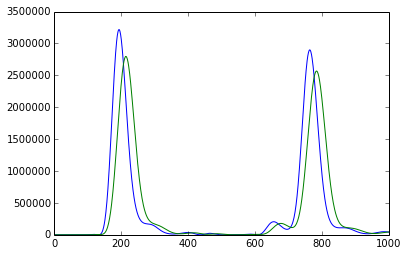

In [98]:
pl.plot(range(1000),fs[:1000,1])
pl.plot(range(1000),fs_smo[:1000,1])

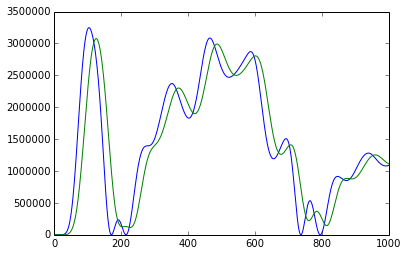

In [99]:
pl.plot(range(1000),fs[:1000,0])
pl.plot(range(1000),fs_smo[:1000,0])

##Parameters

In [13]:
fn = "../train/subj2_series1_data.csv"
data, labels = prepare_data_train(fn)

subjects = range(1,13)
series = range(1,9)
scaler= StandardScaler()
nfilters = 8
csp = CSP(n_components=nfilters, reg='lws')
bands = [[5,10]]
subsample = 50
cut = 50

In [21]:
for subj in subjects:
    for ser in series:
        fn = "../train/subj{}_series{}_data.csv".format(subj,ser)
        data, labels = prepare_data_train(fn)
        y_train = labels["BothReleased"]
        X_train = data_preprocess_train(data,events=labels,sca=1,lpass=5,fbands=bands)
        lr1 = LogisticRegression()
        lr1.fit(X_train[::subsample],y_train[::subsample])
        
        print("subj={}, ser={}, AUC={}".format(subj,ser,eval_lr(lr1,subj,sca=1,lpass=5,fbands=bands)))

subj=1, ser=1, AUC=0.8097535051209639
subj=1, ser=2, AUC=0.7996984077375853
subj=1, ser=3, AUC=0.771722872745078
subj=1, ser=4, AUC=0.8239808514569371
subj=1, ser=5, AUC=0.8055170011129487
subj=1, ser=6, AUC=0.7683460275926859
subj=1, ser=7, AUC=0.8024956892683188
subj=1, ser=8, AUC=0.8160311528415716
subj=2, ser=1, AUC=0.718143969377659
subj=2, ser=2, AUC=0.5038547485091145
subj=2, ser=3, AUC=0.7474469620216715
subj=2, ser=4, AUC=0.769070951656321
subj=2, ser=5, AUC=0.7750707717166844
subj=2, ser=6, AUC=0.7930101907963587
subj=2, ser=7, AUC=0.7701789887897729
subj=2, ser=8, AUC=0.7587305707136314
subj=3, ser=1, AUC=0.6223510972438545
subj=3, ser=2, AUC=0.6476272942059527
subj=3, ser=3, AUC=0.6647951196132416
subj=3, ser=4, AUC=0.6409552459934424
subj=3, ser=5, AUC=0.6723521489430185
subj=3, ser=6, AUC=0.6292707914466685
subj=3, ser=7, AUC=0.6440077382176117
subj=3, ser=8, AUC=0.6433582976985976
subj=4, ser=1, AUC=0.659831851869101
subj=4, ser=2, AUC=0.7208107948490439
subj=4, ser=3, A

In [15]:


y_train = labels["HandStart"]
X_train = data_preprocess_train(data,events=labels,sca=1,lpass=5,fbands=bands)
lr1 = LogisticRegression()
lr1.fit(X_train[::subsample],y_train[::subsample]) 

eval_lr(lr1,2,sca=1,lpass=5,fbands=bands)

0.61378474721388421

In [198]:
y_train = labels["FirstDigitTouch"]
X_train = data_preprocess_train(data,events=labels,sca=1,lpass=3)
lr1 = LogisticRegression()
lr1.fit(X_train[::subsample],y_train[::subsample]) 

eval_lr(lr1,sca=1,lpass=3)

0.54864078152718576

In [161]:
x = np.arange(12).reshape(4,3)

In [168]:
x

array([[ 0,  1,  2],
       [ 3,  4,  5],
       [ 6,  7,  8],
       [ 9, 10, 11]])

In [166]:
x.T

array([[ 0,  3,  6,  9],
       [ 1,  4,  7, 10],
       [ 2,  5,  8, 11]])